# STA250 Project-1
## By Chenghan Sun 

## Note: the required specific details were provided in Section III

## <span style="color:blue"> Section I: Install the required packgaes 

In [ ]:
using Pkg

Pkg.add("SpecialFunctions")
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("LinearAlgebra")
Pkg.add("Statistics")
Pkg.add("Random")
Pkg.add("NLopt")
Pkg.add("PyCall")

In [13]:
Pkg.add("PyPlot")

 Resolving package versions...
 Installed LaTeXStrings ─ v1.0.3
 Installed PyPlot ─────── v2.8.2
  Updating `~/.julia/environments/v1.2/Project.toml`
  [d330b81b] + PyPlot v2.8.2
  Updating `~/.julia/environments/v1.2/Manifest.toml`
  [b964fa9f] + LaTeXStrings v1.0.3
  [d330b81b] + PyPlot v2.8.2


## <span style="color:blue"> Section II: Build environment and import data 

In [1]:
# Define local methods module
module LocalMethods

using SpecialFunctions: besselk, gamma

export ℳ_ν, M_νρσ

tν𝒦t(t,ν) = t^ν * besselk(ν, t)

function ℳ_ν(t, ν)
    pt, pν, p0, p1 = promote(t, ν, 0, 1)
    return (pt==p0) ? p1 : tν𝒦t(√(2pν)*pt,pν) * 2^(1-pν) / gamma(pν)
end

function M_νρσ(t; ν, ρ, σ) #T = L-2 x-y
    return σ * σ * ℳ_ν(t/ρ, ν)
end

end

#M_νρσ.(nrm; )

Main.LocalMethods

In [2]:
# loading packages 
using .LocalMethods 
using CSV
using DataFrames
using PyPlot
using LinearAlgebra
using Statistics
using Random

┌ Info: Recompiling stale cache file /Users/furinkazan/.julia/compiled/v1.2/CSV/HHBkp.ji for CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1240
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1242


In [4]:
# loading data
@show pwd()
data_file = "./data/UStmax.csv"
csv_data  = CSV.File(data_file)
df = DataFrame!(csv_data)  # puts it into a data DataFrame

pwd() = "/Users/furinkazan/Box/STA_250"


,lat,lon,elev,UStmax
,Float64,Float64,Float64,Float64
1,32.95,-85.95,201.0,33.1333
2,33.15,-88.13,49.0,32.2
3,31.32,-86.5,107.0,33.6
4,33.58,-85.85,184.0,32.6333
5,33.27,-85.83,308.0,31.8333
6,31.17,-87.48,92.0,33.3333
7,32.6,-85.5,223.0,32.7667
8,33.45,-87.35,85.0,33.7
9,34.7,-86.88,183.0,32.5


### Summary of Dataset I: 
Mean summer daily maximum temperature for June-August, 1990 at 4408 observation locations in the United States (National Center for Atmospheric Research). Data file `Datasets/Dataset-1-UStmax/data/UStmax.csv` in the Files tab of Canvas has four columns corresponding to latitude, longitude, elevation and mean daily maximum temperature.

## <span style="color:blue"> Section III: Project I -- Specific details

## Project 1 Summary

Model the mean daily maximum temperature as a Gaussian random field (GRF) with Matérn autocovariance. Fit the Matérn parameters `ν, ρ, σ²` using the (GRF) likelihood and use the fitted values for random field prediction (on a dense grid of spatial points over the US) and point-wise uncertainty quantification in terms of the conditional standard deviation of prediction. Compare with bilinear interpolation. 

### <span style="color:red"> (1) First subtract the global mean temperature from all the data points.

In [8]:
# Extract the global mean temperature 
G_tmean = mean(df.UStmax)

-5.931935725038949e-15

In [9]:
# Subtract the global mean temperature from all the data points
df.UStmax = df.UStmax .- G_tmean

4408-element Array{Float64,1}:
  3.942589231699904  
  3.0092558983666096 
  4.409255898366609  
  3.442589231699904  
  2.642589231699907  
  4.142589231699907  
  3.575922565033308  
  4.50925589836661   
  3.3092558983666067 
  5.109255898366604  
  5.275922565033304  
  3.2425892316999083 
  1.6092558983666077 
  ⋮                  
 -3.624077434966695  
  0.8425892316999063 
 -4.257410768300091  
 -0.42407743496669187
 -1.6240774349666947 
 -0.2574107683000915 
 -0.3907441016333924 
  0.44258923169990777
  1.8759225650333053 
  1.0092558983666062 
 -4.357410768300093  
  0.07592256503330812

In [10]:
# Show current DataFrame
df

,lat,lon,elev,UStmax
,Float64,Float64,Float64,Float64
1,32.95,-85.95,201.0,3.94259
2,33.15,-88.13,49.0,3.00926
3,31.32,-86.5,107.0,4.40926
4,33.58,-85.85,184.0,3.44259
5,33.27,-85.83,308.0,2.64259
6,31.17,-87.48,92.0,4.14259
7,32.6,-85.5,223.0,3.57592
8,33.45,-87.35,85.0,4.50926
9,34.7,-86.88,183.0,3.30926


### <span style="color:red"> (2) Then remove a random subset of the mean centered data observations (10% of the data should be fine) and reserve them for a test set to measure quality of prediction at the end. Also use them to test your prediction uncertainty quantification.

In [11]:
# Function for extracting 10% of data for testing purpose 
function subset_extractor(df, test_weight)
    p = shuffle(1:size(df, 1)) # random subset
    train_p = view(p, 1:round(Int,(1-test_weight)*size(df, 1)))
    train_set = df[train_p,:]
    test_p = view(p, round(Int,(1-test_weight)*size(df, 1))+1:size(df, 1))
    test_set = df[test_p,:]
    return train_set, test_set
end

subset_extractor (generic function with 1 method)

In [12]:
# call the function for extracting 10% test set, the remaining part as train set 
train_set, test_set = subset_extractor(df, 0.1)

(3967×4 DataFrame
│ Row  │ lat     │ lon      │ elev    │ UStmax    │
│      │ Float64 │ Float64  │ Float64 │ Float64   │
├──────┼─────────┼──────────┼─────────┼───────────┤
│ 1    │ 47.28   │ -103.9   │ 738.0   │ -0.824077 │
│ 2    │ 42.92   │ -97.38   │ 391.0   │ 1.00926   │
│ 3    │ 45.12   │ -105.82  │ 976.0   │ 0.875923  │
│ 4    │ 38.25   │ -119.23  │ 1972.0  │ -1.52408  │
│ 5    │ 30.52   │ -101.17  │ 653.0   │ 3.14259   │
│ 6    │ 47.43   │ -122.3   │ 117.0   │ -5.19074  │
│ 7    │ 36.1    │ -82.85   │ 402.0   │ 0.842589  │
│ 8    │ 42.88   │ -100.55  │ 787.0   │ 0.809256  │
│ 9    │ 37.8    │ -80.0    │ 375.0   │ 1.84259   │
│ 10   │ 37.15   │ -92.27   │ 442.0   │ 1.24259   │
⋮
│ 3957 │ 42.55   │ -87.82   │ 180.0   │ -4.75741  │
│ 3958 │ 31.65   │ -81.85   │ 31.0    │ 5.80926   │
│ 3959 │ 26.1    │ -80.2    │ 5.0     │ 3.24259   │
│ 3960 │ 32.02   │ -102.02  │ 836.0   │ 5.47592   │
│ 3961 │ 37.93   │ -98.03   │ 479.0   │ 4.54259   │
│ 3962 │ 31.32   │ -86.5    │ 107.0   │ 4.40

Here, a random subset of the mean centered data observations (10%) with **441 rows** as testing dataset, and **3967 rows** as remaining set (training set).

### <span style="color:red"> (3) When fitting the Matérn parameters you can restrict `ν ∈ {1/2, 3/2, 5/2, 7/2, ...}`. Also keep in mind that there will be a flat ridge in the loglikelihood for each fixed `ν` which should corresponds to `σ² = constant * ρ^(2ν)` so finding a strictly optimal set of parameters `ν, ρ, σ²` will be quite difficult. I am looking for a reasonable choice of `ν, ρ, σ²` that has a loglikelihood value which is arguably `± (10)` of the MLE.

In [13]:
# construct cov matrix
function calc_nrm(train_set, test_set)
    nrm_train = sqrt.((train_set.lat .- train_set.lat').^2 .+ (train_set.lon .- train_set.lon').^2)
    nrm_train_test = sqrt.((train_set.lat .- test_set.lat').^2 .+ (train_set.lon .- test_set.lon').^2)
    nrm_test = sqrt.((test_set.lat .- test_set.lat').^2 .+ (test_set.lon .- test_set.lon').^2)
    return nrm_train, nrm_train_test, nrm_test
end

calc_nrm (generic function with 1 method)

In [14]:
# nrm matrices 
nrm_train, nrm_train_test, nrm_test = calc_nrm(train_set, test_set)
#@show nrm_train
#@show nrm_train_test
#@show nrm_test

([0.0 7.843468620451039 … 19.219190929901288 23.177724219603622; 7.843468620451039 0.0 … 22.598028675085807 15.335230679712648; … ; 19.219190929901288 22.598028675085807 … 0.0 33.63449717180265; 23.177724219603622 15.335230679712648 … 33.63449717180265 0.0], [9.235069030602858 17.580025597250994 … 10.343742069483367 8.632554662439155; 7.5913174087242625 10.192492335047396 … 3.3206324698767795 0.8261961026293871; … ; 15.578863886689563 31.89427848376571 … 25.9000482625033 22.850350106727035; 18.832493196600392 7.804511515783675 … 13.429121341323867 14.547140612505272], [0.0 16.315452797884586 … 10.69544295482894 7.613310712167207; 16.315452797884586 0.0 … 7.238818964444409 9.61699017364581; … ; 10.69544295482894 7.238818964444409 … 0.0 3.0886890422961026; 7.613310712167207 9.61699017364581 … 3.0886890422961026 0.0])

In [22]:
# function for the loglikelihood 
function MLE(nrm, z, ν, ρ, σ)
    Σ = M_νρσ.(nrm; ν=ν, ρ=ρ, σ=σ) |> Symmetric
    ch = cholesky(Σ)
    ch_lower = ch.L
    # suggested to define new variable for ch_lower\z 
    return -0.5 * dot(ch_lower\z, ch_lower\z) - sum(log.(diag(ch_lower))) #by using the expression in notes
end

MLE (generic function with 2 methods)

### <span style="color:red"> (3).1 Begin Optimization: optimize the MLE with optimal values of ρ, σ
### <span style="color:red"> First using LN_NELDERMEAD optimizer used in julia-3.jl

In [23]:
using NLopt

### For $\nu=\frac12$

In [24]:
# call the MLE function
llmax = function(x)
    return MLE(nrm_train, train_set.UStmax, 0.5, x[1], x[2])
end

opt1 = Opt(:LN_NELDERMEAD, 2) # using the optimizer picked from julia-3.jl
opt1.max_objective = (x, grad) -> llmax(x)
# Note: could use MLE point to optimizer to prevent global variables issue

#9 (generic function with 1 method)

In [28]:
opt1.lower_bounds = [0.1, 0.1]
opt1.upper_bounds = [50.0, 50.0]
optf1, optx1, ret1 = optimize(opt1, Float64[25,25]) #start from the middle

(-5203.284883899491, [1.1431971490358848, 3.8777562138773285], :XTOL_REACHED)

### For $\nu=\frac32$

In [29]:
llmax2=function(x)
    return MLE(nrm_train, train_set.UStmax, 1.5, x[1], x[2])
end

opt2 = Opt(:LN_NELDERMEAD, 2)
opt2.max_objective = (x,grad) -> llmax2(x)

opt2.lower_bounds = [0.1, 0.1]
opt2.upper_bounds = [50.0, 50.0]
optf2, optx2, ret2 = optimize(opt2, Float64[25,25])

(-7325.635820849081, [0.1000000000000022, 3.924390020951096], :XTOL_REACHED)

### For $\nu=\frac52$

In [30]:
llmax3 = function(x)
    return MLE(nrm_train, train_set.UStmax, 2.5, x[1], x[2])
end

opt3 = Opt(:LN_NELDERMEAD, 2)
opt3.max_objective = (x,grad) -> llmax3(x)

opt3.lower_bounds = [0.1, 0.1]
opt3.upper_bounds = [50.0, 50.0]
optf3, optx3, ret3 = optimize(opt3, Float64[25,25])

(-7378.528807646988, [0.1000000000000022, 3.9916311575706174], :XTOL_REACHED)

### For $\nu=\frac72$

In [33]:
llmax4 = function(x)
    return MLE(nrm_train, train_set.UStmax, 3.5, x[1], x[2])
end

opt4 = Opt(:LN_NELDERMEAD, 2)
opt4.max_objective = (x,grad) -> llmax4(x)

opt4.lower_bounds = [0.1, 0.1]
opt4.upper_bounds = [50.0, 50.0]
optf4, optx4, ret4 = optimize(opt4, Float64[1,1])

(-7407.420680024532, [0.1, 4.028582566976546], :XTOL_REACHED)

**Note: From the upper tests for  `ν ∈ {1/2, 3/2, 5/2, 7/2}`, it's observed that using `ν = 1/2` gives maximum likelihood comparing with the other three cases `ν = {3/2, 5/2, 7/2}`, and it's observed that the value of likelihood is decreasing as ν increasing. Thus, `ν = 1/2` is the optimal value. Furthermore, the optimal values for ρ, σ are approximately 1.143, 3.878, respectively.**

### <span style="color:red"> (3).2: Choosing other optimizers: 
### LN_BOBYQA

In [47]:
llmax5 = function(x)
    return MLE(nrm_train, train_set.UStmax, 0.5, x[1], x[2])
end

opt5 = Opt(:LN_BOBYQA, 2) 
opt5.max_objective = (x, grad) -> llmax5(x)

opt5.lower_bounds = [0.1, 0.1]
opt5.upper_bounds = [50.0, 50.0]
optf5, optx5, ret5 = optimize(opt5, Float64[25,25]) #start from the middle

(-5203.284883899489, [1.143196988234036, 3.877755967514583], :ROUNDOFF_LIMITED)

### LN_PRAXIS

In [52]:
llmax7 = function(x)
    return MLE(nrm_train, train_set.UStmax, 0.5, x[1], x[2])
end

opt7 = Opt(:LN_PRAXIS, 2) 
opt7.max_objective = (x, grad) -> llmax7(x)

opt7.lower_bounds = [0.1, 0.1]
opt7.upper_bounds = [50.0, 50.0]
optf7, optx7, ret7 = optimize(opt7, Float64[25,25]) #start from the middle

(-5203.284883899485, [1.143197095497273, 3.8777561165522085], :SUCCESS)

###  LN_SBPLX

In [53]:
llmax8 = function(x)
    return MLE(nrm_train, train_set.UStmax, 0.5, x[1], x[2])
end

opt8 = Opt(:LN_SBPLX, 2) 
opt8.max_objective = (x, grad) -> llmax8(x)

opt8.lower_bounds = [0.1, 0.1]
opt8.upper_bounds = [50.0, 50.0]
optf8, optx8, ret8 = optimize(opt8, Float64[1,1]) #start from the middle

(-5203.284883899487, [1.1431970047997326, 3.877756070392206], :XTOL_REACHED)

### Summary：
**By using four different optimization methods, all the optimizer above attained the same MLE, which should be in ± (10) of the MLE. It's conclude that ν = 1/2 is the optimal value. Furthermore, the optimal values for ρ, σ are approximately 1.143, 3.878, respectively.**

### <span style="color:red">3.3: Using the optimal set of ν, ρ, σ from above analysis to construct cov-matrices

In [48]:
Σ_train = M_νρσ.(nrm_train; ν=0.5, ρ=1.1431971490358848, σ=3.8777562138773285)

3967×3967 Array{Float64,2}:
 15.037         0.0157568     1.20025      …   7.51438e-7    2.35542e-8 
  0.0157568    15.037         0.00730656       3.91103e-8    2.24589e-5 
  1.20025       0.00730656   15.037            9.17897e-6    1.47816e-8 
  2.61899e-6    4.88641e-8    2.83894e-5       0.623326      1.01152e-12
  5.32369e-6    0.00017838    2.27082e-5       2.69547e-6    6.4154e-6  
  1.53768e-6    3.60079e-9    7.16626e-6   …   0.000132607   1.15928e-14
  1.32578e-8    1.20085e-5    6.34298e-9       4.46735e-13   1.34747    
  0.119203      0.939289      0.100409         5.09978e-7    2.16846e-6 
  2.56747e-9    1.96813e-6    9.5877e-10       3.39147e-14   0.0769743  
  2.07963e-5    0.0177475     1.60382e-5       1.56902e-9    0.0131537  
  0.0784429     0.244519      0.0105764    …   9.24826e-9    1.10795e-6 
  0.000512372   1.29441e-6    0.00259099       0.000377118   3.64408e-12
  2.58723e-7    3.94455e-9    2.64812e-6       0.195646      8.38434e-14
  ⋮                    

In [49]:
Σ_train_test = M_νρσ.(nrm_train_test; ν=0.5, ρ=1.1431971490358848, σ=3.8777562138773285)

3967×441 Array{Float64,2}:
 0.00466453  3.15212e-6   9.03255e-7   …  0.0017686    0.00790132 
 0.0196454   0.00201877   1.44286e-8      0.823513     7.29951    
 0.0210172   1.01048e-6   9.41832e-6      0.000526954  0.00406331 
 1.24355e-5  9.43965e-12  4.25862         2.68398e-9   3.51987e-8 
 0.0160364   2.74826e-6   1.57452e-7      3.04989e-5   0.000265389
 1.2693e-7   4.86433e-13  0.00462487   …  2.51565e-10  2.08722e-9 
 2.52698e-7  0.0322871    6.08963e-14     9.60679e-5   2.28077e-5 
 0.122243    0.000129033  2.19114e-7      0.0536987    0.575536   
 2.26679e-8  0.011646     5.31537e-15     2.16669e-5   3.52517e-6 
 0.00100614  0.0446465    2.39246e-10     0.0363686    0.0365075  
 0.00107363  0.000341932  6.87983e-9   …  0.140014     0.130275   
 3.02343e-5  1.75468e-10  0.00343918      9.09078e-8   7.44254e-7 
 9.93406e-7  7.47942e-13  4.11022         2.17141e-10  2.81768e-9 
 ⋮                                     ⋱               ⋮          
 3.37683e-9  0.000838729  8.23518e-

In [51]:
Σ_test = M_νρσ.(nrm_test; ν=0.5, ρ=1.1431971490358848, σ=3.8777562138773285)

441×441 Array{Float64,2}:
 15.037         9.52813e-6    3.52585e-6   …   0.00130023    0.019271   
  9.52813e-6   15.037         2.71414e-12      0.0267407     0.00333978 
  3.52585e-6    2.71414e-12  15.037            7.94365e-10   1.02947e-8 
  0.0104735     6.32946e-7    9.86417e-6       0.00034171    0.00238638 
  4.10086e-5    0.196738      9.79719e-12      0.00614913    0.00260419 
  9.05495e-9    0.00763222    2.15308e-15  …   1.35836e-5    1.85883e-6 
  0.0467503     0.00129207    2.73711e-8       0.394172      5.65491    
  8.73468e-9    4.85495e-5    3.93938e-15      3.20674e-7    1.48922e-7 
  0.054184      2.47097e-6    6.1093e-6        0.00121642    0.0105281  
  4.2855e-9     0.000897353   1.05781e-15      1.93163e-6    3.95233e-7 
  9.84078e-5    0.00592899    3.48711e-11  …   0.000825745   0.000903756
  9.40279e-11   0.000147337   2.71626e-17      4.17881e-7    3.77522e-8 
  0.00533661    0.000478939   2.82154e-9       0.00125528    0.00469424 
  ⋮                      

In [60]:
# The predicted values given by
pred_val = Σ_train_test' * (Σ_train \ train_set.UStmax)

441-element Array{Float64,1}:
  3.31054817271814    
 -1.979339041787342   
  1.6296933849118163  
  0.013744379605563337
  2.7881113288745683  
 -2.355418222085728   
  0.4824234258316996  
  3.243205913790061   
 -1.2550936729184912  
  3.042164047859704   
  4.54758908450716    
 -5.0092681760857465  
  4.356736420072626   
  ⋮                   
 -5.513947318391874   
 -9.83171629828342    
 -1.0175310400544173  
  3.1484245705045617  
 -3.3180096338710916  
 -3.954735719027959   
 -2.1806462126417276  
 -9.182400622021344   
  3.3498491209795827  
  5.31523455578932    
 -2.1172823374919476  
  0.4924706852756107  

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1242


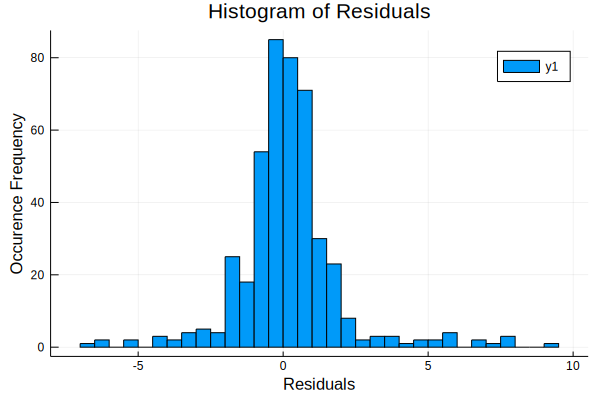

In [74]:
# The residuals given by histogram plot
using Plots
res = pred_val - test_set.UStmax
histogram(res, xlabel="Residuals", ylabel="Occurence Frequency", title="Histogram of Residuals")

In [75]:
# Report the RMSE
@show rmse = sqrt(sum(res.^2.) / length(res))

rmse = sqrt(sum(res .^ 2.0) / length(res)) = 1.818770528177


1.818770528177

### Summary
**From the analysis of Matérn GRF prediction above,we see the performance of selected Matérn parameters work well with the predictive mean daily maximum temperature, with the RMSE = 1.819.**

### <span style="color:red"> (4) Besides comparing Matérn GRF prediction and bilinear interpolation, also include a comparison when using the Gaussian autocovariance model `K(t) = σ² exp(-t²/ρ²)`. Summarize any numerical issues you encounter. 

In [91]:
# using code from Julia-4.jl
using PyCall
scii = pyimport("scipy.interpolate")

PyObject <module 'scipy.interpolate' from '/Users/furinkazan/.julia/conda/3/lib/python3.7/site-packages/scipy/interpolate/__init__.py'>

In [192]:
px = train_set.lon
py = train_set.lat
pf = train_set.UStmax

# define the resolution
nxgrid = 600
nygrid = 600
lat_min, lat_max = extrema(df.lat)
lon_min, lon_max = extrema(df.lon)

X = range(lon_min, lon_max, length=nxgrid) .+ fill(0, nxgrid, nygrid) 
Y = range(lat_min, lat_max, length=nygrid)' .+ fill(0, nxgrid, nygrid) 

600×600 Array{Float64,2}:
 24.55  24.5908  24.6316  24.6725  …  48.8775  48.9184  48.9592  49.0
 24.55  24.5908  24.6316  24.6725     48.8775  48.9184  48.9592  49.0
 24.55  24.5908  24.6316  24.6725     48.8775  48.9184  48.9592  49.0
 24.55  24.5908  24.6316  24.6725     48.8775  48.9184  48.9592  49.0
 24.55  24.5908  24.6316  24.6725     48.8775  48.9184  48.9592  49.0
 24.55  24.5908  24.6316  24.6725  …  48.8775  48.9184  48.9592  49.0
 24.55  24.5908  24.6316  24.6725     48.8775  48.9184  48.9592  49.0
 24.55  24.5908  24.6316  24.6725     48.8775  48.9184  48.9592  49.0
 24.55  24.5908  24.6316  24.6725     48.8775  48.9184  48.9592  49.0
 24.55  24.5908  24.6316  24.6725     48.8775  48.9184  48.9592  49.0
 24.55  24.5908  24.6316  24.6725  …  48.8775  48.9184  48.9592  49.0
 24.55  24.5908  24.6316  24.6725     48.8775  48.9184  48.9592  49.0
 24.55  24.5908  24.6316  24.6725     48.8775  48.9184  48.9592  49.0
  ⋮                                ⋱                            

### <span style="color:red"> (4).1 Bilinear interpolation as well as nearest and cubic cases

In [194]:
griddata = scii.griddata

fn = griddata((px, py), pf, (X, Y), method="nearest")
fl = griddata((px, py), pf, (X, Y), method="linear")
fc = griddata((px, py), pf, (X, Y), method="cubic")

600×600 Array{Float64,2}:
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  Na

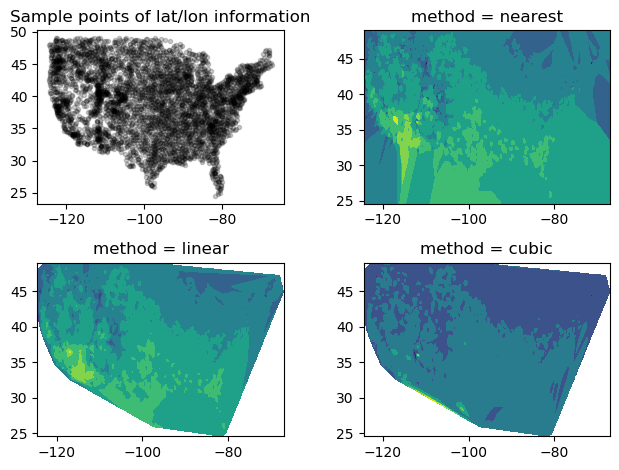

In [195]:
# Make plots
fig, ax = subplots(nrows=2, ncols=2)

ax[1,1].scatter(px, py, c="k", alpha=0.2, marker=".")
ax[1,1].set_title("Sample points of lat/lon information")

for (method,finterp,rc) ∈ zip(("nearest","linear","cubic"), (fn, fl, fc),((1,2),(2,1),(2,2)))
    ax[rc[1],rc[2]].contourf(X, Y, finterp)
    ax[rc[1],rc[2]].set_title("method = $method")
end

tight_layout()

In [197]:
# predicted values of three linear methods 
pred_nearest = griddata((px, py), pf, (test_set.lon, test_set.lat), method="nearest")
pred_linear = griddata((px, py), pf, (test_set.lon, test_set.lat), method="linear")
pred_cubic = griddata((px, py), pf, (test_set.lon, test_set.lat), method="cubic")

441-element Array{Float64,1}:
  2.8166138811484296
 -1.5965400358770498
  0.9692203797489981
 -1.0231558432033645
  3.8194788269362347
 -3.9121268296759113
  0.6903470144987244
  3.527676653097658 
 -7.573146853472993 
  3.3925242095570125
  4.488735481887657 
 -4.911163113246818 
  4.687456042558155 
  ⋮                 
 -4.4229687989197   
 -4.9616367571408215
 -1.4082215089499277
  3.376169434634611 
 -2.8411339639234647
 -3.4191826824543763
 -1.3116535035235088
 -9.212991648760479 
  2.825268036816623 
  5.335577870961197 
 -1.9307873836680383
  0.5668885015152995

In [198]:
# find residuals 
res_nearest = pred_nearest - test_set.UStmax
res_linear = pred_linear - test_set.UStmax
res_cubic = pred_cubic - test_set.UStmax

441-element Array{Float64,1}:
 -2.125975350551475  
  1.0942040657563434 
 -3.573368851950908  
 -2.73241174156997   
  2.0768895952363264 
 -4.554716061375818  
  0.7144244494654177 
 -0.5149125786022477 
 -7.749069418506299  
  0.34993497785710703
 -0.12052041647894729
  1.0129143217198733 
 -0.2551331891417492 
  ⋮                  
  2.5677753027136934 
  8.595774011159271  
  0.882522592683467  
  0.8669135362680049 
  0.8496101377099285 
  0.804894752512316  
  1.345757264776585  
  2.7777524528729156 
 -1.2506545282166854 
  0.12632197259459144
  0.35995671796535644
 -0.709034063518008  

In [212]:
# drop out all the NaN values
using Missings
dropmissingNaN(x)= filter( x->(!isnan(x)), Missings.coalesce.( x , NaN ) )
res_nearest = dropmissingNaN(res_nearest)
res_linear = dropmissingNaN(res_linear)
res_cubic = dropmissingNaN(res_cubic)

440-element Array{Float64,1}:
 -2.125975350551475  
  1.0942040657563434 
 -3.573368851950908  
 -2.73241174156997   
  2.0768895952363264 
 -4.554716061375818  
  0.7144244494654177 
 -0.5149125786022477 
 -7.749069418506299  
  0.34993497785710703
 -0.12052041647894729
  1.0129143217198733 
 -0.2551331891417492 
  ⋮                  
  2.5677753027136934 
  8.595774011159271  
  0.882522592683467  
  0.8669135362680049 
  0.8496101377099285 
  0.804894752512316  
  1.345757264776585  
  2.7777524528729156 
 -1.2506545282166854 
  0.12632197259459144
  0.35995671796535644
 -0.709034063518008  

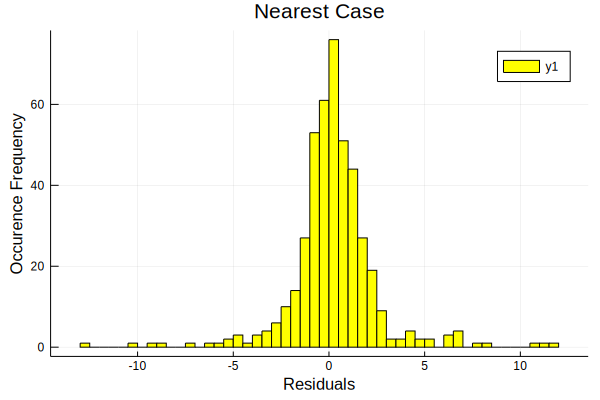

In [213]:
# Nearest case given by histogram plot
histogram(res_nearest, xlabel="Residuals", ylabel="Occurence Frequency", title="Nearest Case", seriescolor = "yellow")

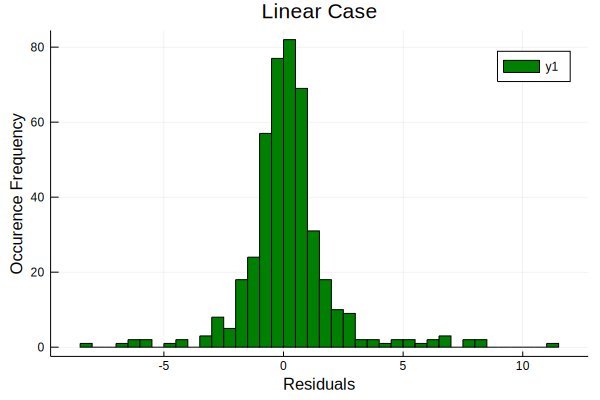

In [214]:
# Linear case given by histogram plot
histogram(res_linear, xlabel="Residuals", ylabel="Occurence Frequency", title="Linear Case", seriescolor = "green")

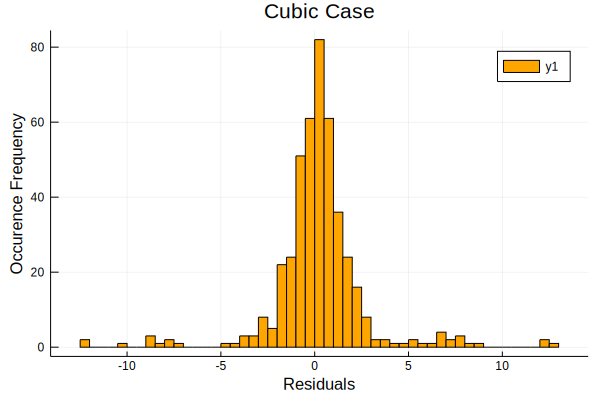

In [215]:
# Cubic case given by histogram plot
histogram(res_cubic, xlabel="Residuals", ylabel="Occurence Frequency", title="Cubic Case", seriescolor = "orange")

In [216]:
# report RMSEs
@show rmse_nearest = sqrt(sum(res_nearest.^2) / length(res_nearest))
@show rmse_linear = sqrt(sum(res_linear.^2) / length(res_linear))
@show rmse_cubic = sqrt(sum(res_cubic.^2) / length(res_cubic))

rmse_nearest = sqrt(sum(res_nearest .^ 2) / length(res_nearest)) = 2.3093939853327456
rmse_linear = sqrt(sum(res_linear .^ 2) / length(res_linear)) = 1.9256468622992833
rmse_cubic = sqrt(sum(res_cubic .^ 2) / length(res_cubic)) = 2.5228215460444225


2.5228215460444225

### Summary
**It's observed that there are NaN data points in residual set for the cases of linear and cubic. After drop out NaN (one NaN for each case),the bilinear interpolation has RMSE = 1.9256468622992833.**

### <span style="color:red"> (4).2 Using second method: LinearNDInterpolator

In [217]:
LinNDInterp = scii.LinearNDInterpolator

fL = LinNDInterp((px, py), pf) # note: fL is automatically vectorized

PyObject <scipy.interpolate.interpnd.LinearNDInterpolator object at 0x155ae3110>

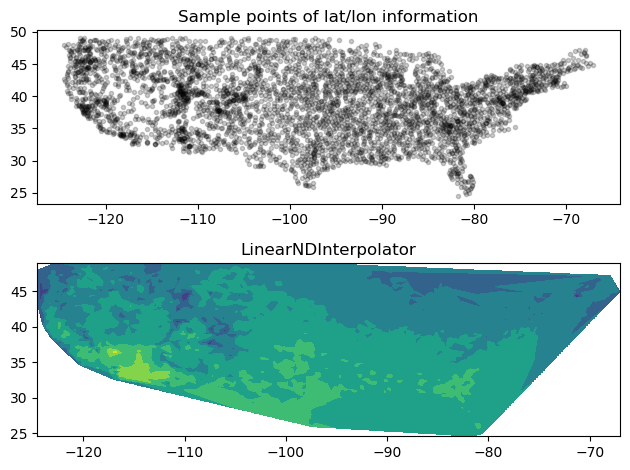

In [218]:
# Make plot
fig, ax = subplots(nrows=2, ncols=1)

ax[1].scatter(px, py, c="k", alpha=0.2, marker=".")
ax[1].set_title("Sample points of lat/lon information")

ax[2].contourf(X, Y, fL.(X, Y))
ax[2].set_title("LinearNDInterpolator")

tight_layout()

In [219]:
# predicted values using linearND methods 
pred_linearND = fL(test_set.lon, test_set.lat)

441-element Array{Float64,1}:
   2.973616707625384  
  -1.854559162541452  
   1.8194466185487617 
  -0.5077604498003339 
   3.0479352467868264 
  -2.47212151210172   
   0.43929827124797005
   3.3423080924749202 
  -2.466151571016771  
   2.9191650408992444 
   4.432790456546823  
  -4.863940596652013  
   4.566725240618582  
   ⋮                  
  -4.767489431033608  
 -10.97956654818927   
  -1.5929973636900823 
   2.946744606587056  
  -3.533995494619336  
  -3.9168943906507385 
  -2.070623203533215  
  -9.191436912091099  
   2.9576258957161747 
   5.32922268956625   
  -2.005488453595378  
   0.30437267119039507

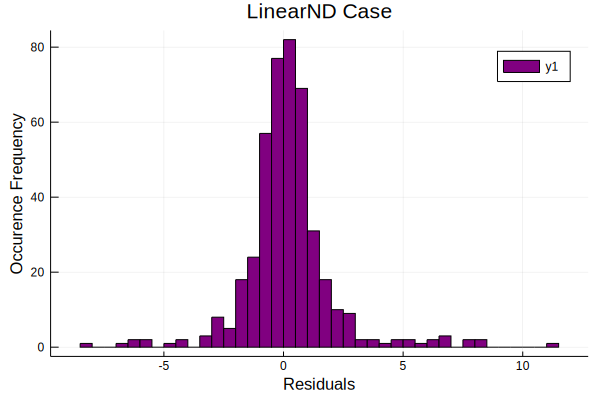

In [221]:
# find residuals and histogram plot
res_linearND = pred_linearND - test_set.UStmax
# remove the NaN values
res_linearND = dropmissingNaN(res_linearND)
histogram(res_linearND, xlabel="Residuals", ylabel="Occurence Frequency", title="LinearND Case", seriescolor = "purple")


In [222]:
# report RMSE
rmse_linearND = sqrt(sum(res_linearND.^2) / length(res_linearND))

1.9256468622992833

### Summary
**The performance of interpolation by using LinearNDInterpolator is the same as the previous linear method in part (4).1.**

### <span style="color:red">(4).3 Using Gaussian autocovariance model `K(t) = σ² exp(-t²/ρ²)`

In [223]:
# define the function of Gaussian autocovariance model
Gaussian_AutoCov = function(t)
    K_t = σ * σ * exp( - t^2/ρ^2)
    return K_t
end

#97 (generic function with 1 method)

In [224]:
# function for the loglikelihood 
function MLE_GAC(nrm, z, ρ, σ) #GAC = Gaussian AutoCovariance
    Σ = Gaussian_AutoCov.(nrm) |> Symmetric
    ch = cholesky(Σ)
    ch_lower = ch.L
    return  - 0.5 * dot(ch_lower\z, ch_lower\z) - sum(log.(diag(ch_lower)))
end

MLE_GAC (generic function with 1 method)

In [225]:
# Using the pre-determined optimal values of ρ, σ to construct cov matrices
ρ=1.1431971490358848
σ=3.8777562138773285
nrm_GAV_train = Gaussian_AutoCov.((train_set.lat .- train_set.lat').^2 .+ (train_set.lon .- train_set.lon').^2)

3967×3967 Array{Float64,2}:
 15.037          0.0            9.92315e-23   …   0.0            0.0        
  0.0           15.037          0.0               0.0            0.0        
  9.92315e-23    0.0           15.037             0.0            0.0        
  0.0            0.0            0.0               7.98358e-58    0.0        
  0.0            0.0            0.0               0.0            0.0        
  0.0            0.0            0.0           …   0.0            0.0        
  0.0            0.0            0.0               0.0            9.0726e-19 
  2.35585e-310   4.07179e-33    0.0               0.0            0.0        
  0.0            0.0            0.0               0.0            0.0        
  0.0            0.0            0.0               0.0            0.0        
  0.0            6.35466e-163   0.0           …   0.0            0.0        
  0.0            0.0            0.0               0.0            0.0        
  0.0            0.0            0.0             

In [226]:
nrm_GAV_train_test = Gaussian_AutoCov.((train_set.lat .- test_set.lat').^2 .+ (train_set.lon .- test_set.lon').^2)

3967×441 Array{Float64,2}:
 0.0           0.0         0.0           …  0.0            0.0         
 0.0           0.0         0.0              5.93028e-40   10.5275      
 0.0           0.0         0.0              0.0            0.0         
 0.0           0.0         0.548857         0.0            0.0         
 0.0           0.0         0.0              0.0            0.0         
 0.0           0.0         0.0           …  0.0            0.0         
 0.0           0.0         0.0              0.0            0.0         
 6.19515e-304  0.0         0.0              0.0            6.88215e-64 
 0.0           0.0         0.0              0.0            0.0         
 0.0           0.0         0.0              0.0            0.0         
 0.0           0.0         0.0           …  5.09993e-271   3.77657e-288
 0.0           0.0         0.0              0.0            0.0         
 0.0           0.0         0.372248         0.0            0.0         
 ⋮                                   

In [227]:
nrm_GAV_test = Gaussian_AutoCov.((test_set.lat .- test_set.lat').^2 .+ (test_set.lon .- test_set.lon').^2)

441×441 Array{Float64,2}:
 15.037         0.0            0.0    …   0.0           0.0         
  0.0          15.037          0.0        0.0           0.0         
  0.0           0.0           15.037      0.0           0.0         
  0.0           0.0            0.0        0.0           0.0         
  0.0           3.01351e-200   0.0        0.0           0.0         
  0.0           0.0            0.0    …   0.0           0.0         
  0.0           0.0            0.0        2.37234e-99   4.54913     
  0.0           0.0            0.0        0.0           0.0         
  0.0           0.0            0.0        0.0           0.0         
  0.0           0.0            0.0        0.0           0.0         
  0.0           0.0            0.0    …   0.0           0.0         
  0.0           0.0            0.0        0.0           0.0         
  0.0           0.0            0.0        0.0           0.0         
  ⋮                                   ⋱                 ⋮           
  0.0   

In [228]:
# predicted values using Gaussian AutoCovariance methods 
pred_GAC = nrm_GAV_train_test' * (nrm_GAV_train \ train_set.UStmax)

441-element Array{Float64,1}:
    26.713426216767402
    86.45101597447592 
 -1071.7802388023192  
 -1500.202584866667   
   -94.63744237006176 
  -653.3991134176613  
  2462.02402830947    
   -46.838966696745274
   290.9582375438031  
 -1160.4053831640103  
   -71.7340256546347  
  1343.9109007726456  
   168.7685516801921  
     ⋮                
  -701.3634539555005  
   318.1627546376403  
  -856.6475575699005  
  1018.6313792542428  
   991.3941883282274  
    -8.204429832752794
   -98.61236254456526 
  -162.87276497214725 
   -74.30719843212319 
    48.06509100161293 
   111.21030420349734 
  1514.9612015676357  

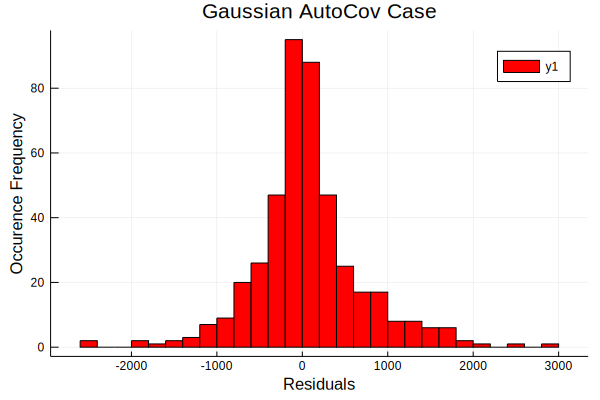

In [229]:
# Find the residuals and make histogram plot
res_GAC = pred_GAC - test_set.UStmax
histogram(res_GAC, xlabel="Residuals", ylabel="Occurence Frequency", title="Gaussian AutoCov Case", seriescolor = "red")

In [230]:
# report RMSE
rmse_GAC = sqrt(sum(res_GAC.^2.) / length(res_GAC))

639.767336650462

### Summary
**By using the Gaussian Auto-Covariance method, the RMESE is found to be 639.767336650462. Combining with the histogram plot, it's conclude that this method is way too worse comparing with the previous methods.** 

### <span style="color:red">(4).4 Summary of numerical issues: 

**(1) The major numerical issue that I found is the NaN values existed in the residual vectors for the bilinear interpolation cases (both scipy.interpolator and LinearNDInterpolator) and cubic case. By dropping out the NaN value (one NaN for each above mentioned methods), it is observed that the performance of Gaussian autocovariance model is way too worse than Matérn GRF prediction or bilinear interpolation.**

**(2) The mean reason that Gaussian autocovariance model is not accurate for testing set is resulting from the numerical underflow during calculation on covariance matrices, where the norm matrices contained too many small values.**

### <span style="color:red"> (5) Write up a report which summaries your findings and submit in either pdf form or jupyter notebook form. This report should include code snippets, images showing the spatial prediction maps and summaries of any numerical issues you encounter.

### Summary of Project I
**All the code snippets, images showing the spatial prediction maps, and summaries of any numerical issues were provided in Section III above. In conclusion, comparing three major methods:** 

**(1) Matérn GRF prediction: RMSE = 1.818770528177 (Optimal parameters: ν = 1/2, ρ = 1.143, σ = 3.878)**

**(2) Bilinear interpolation: RMSE = 1.9256468622992833**

**(3) Gaussian autocovariance model: RMSE = 639.767336650462**

**Method (1) is the best comparing the other two models.**

**(Note: The corresponding distributions of residual for the three methods can be found the each subsection of section III)**